In [ ]:
# default_exp params

# Params for common algorithms

This is the module to generate some boilerplate hyperparameters for some common used algorithms such Xgboost or lgboost or catboost. More functions to come...

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# export
import random
import numpy as np
from fastcore.test import *
import xgboost
from sklearn.ensemble import RandomForestClassifier
from Yikai_helper_funcs import * 
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [ ]:
def get_data():
    """Synthetic binary classification dataset."""
    data, targets = make_classification(
        n_samples=1000,
        n_features=45,
        n_informative=12,
        n_redundant=7,
        random_state=134985745,
    )
    return data, targets


x, y = get_data()

In [ ]:
# exporti

class HyperparamsGenerator:

    """
    This is the base class for {algo}ParamGenerator 
    Kwargs are to passed into the param-greis
    
    """

    def __init__(self, **kwargs):
        self.kwargs = kwargs

    @property
    def params_included(self):
        return self.matrix_generation()
    
    def matrix_generation(self):

        param_matrix = {
            **self.kwargs
                }
        print('Please make sure to set "int" for certain parameters when you pass them to the model')
        
        return param_matrix

In [ ]:
# export
class XgboostParamGenerator(HyperparamsGenerator):

    def matrix_generation(self):

        param_matrix = {
            'n_estimators': (5, 100),
            'max_depth': (3, 12),
            'min_child_weight': (0.01, 0.6),
            'gamma': (0.1, 40),
            'learning_rate': (0.005,0.3),
            'subsample': (0.05,1.0),
            **self.kwargs
                }
        return param_matrix


In [ ]:
assert len(XgboostParamGenerator().params_included) == 6

In [ ]:
# export
class LgbmParamGenerator(HyperparamsGenerator):

    def matrix_generation(self):
        """
        Generate common param_matric for Lgbm;
        Notice that when the parameter is supposed to be the float type, the parameter bound should also be put as float,
        for example, 0. as the lower bound for "reg_alpha", instead of 0 
        
        """

        param_matrix = {
            #'class_weight': [None, 'balanced'],
            #'boosting_type': ['gbdt', 'goss', 'dart'],
            'num_leaves': (30, 200),
            'learning_rate': (0.005,0.3),
            #'subsample_for_bin': list(range(20000, 300000, 20000)),
            'min_child_samples': (20, 500),
            'reg_alpha': (0., 0.99),
            'reg_lambda': (0., 0.99), 
            'colsample_bytree': (0.6, 1),
            **self.kwargs
                }
        return param_matrix

In [ ]:
assert len(LgbmParamGenerator(num_leaves = np.array([1,2,3])).params_included) == 6

Test if we could pass in any modification to the param_matric within the generator

In [ ]:
test_eq(LgbmParamGenerator(num_leaves = np.array([1,2,3])).params_included['num_leaves'], np.array([1,2,3]))

In [ ]:
# export
class CatParamGenerator(HyperparamsGenerator):

    def matrix_generation(self):

        param_matrix = {
                'iterations':  (10, 1000),
                 'depth': (2, 15),
                 'learning_rate': (0.005,0.3),
                 'bagging_temperature': (0.0, 1.0), 
                 'border_count': (1, 255),
                 'l2_leaf_reg': (2, 30),
                 'scale_pos_weight': (0.1, 1),
            **self.kwargs
                }
        return param_matrix

In [ ]:
test_eq(CatParamGenerator(iterations = np.array([1,2,3])).params_included['iterations'], np.array([1,2,3]))

In [ ]:
CatParamGenerator().params_included.keys()

dict_keys(['iterations', 'depth', 'learning_rate', 'bagging_temperature', 'border_count', 'l2_leaf_reg', 'scale_pos_weight'])

In [ ]:
# export
class RFParamGenerator(HyperparamsGenerator):

    def matrix_generation(self):

        param_matrix = {
                'n_estimators': (20, 500)
                , 'min_samples_split': (2, 100)
                #, 'max_features': random.randint(1, max(2, n_features))
                , 'max_depth': (20, 105)
                #, 'criterion': random.choice(['gini', 'entropy'])
                , 'ccp_alpha': (0.01, 0.1),
                 **self.kwargs
                }
        return param_matrix

## Test if we could connect these param_matrix to bayes_opt

### Test for random forest

In [ ]:
RFParamGenerator().params_included

{'n_estimators': (20, 500),
 'min_samples_split': (2, 100),
 'max_depth': (20, 105),
 'ccp_alpha': (0.01, 0.1)}

In [ ]:

params_forest = RFParamGenerator().matrix_generation()
@optimize_bayes_param(X=x, y=y)
def optimize_forest(n_estimators, min_samples_split, max_depth , ccp_alpha):
    return RandomForestClassifier(n_estimators=int(n_estimators), min_samples_split=int(min_samples_split),  max_depth = int(max_depth), ccp_alpha = float(ccp_alpha), n_jobs=-1)

In [ ]:
best_rf = optimize_forest(init_points=5, n_iter=10, pbounds=params_forest, log_dir="./bayes_opt_logs/forest")


The best combination of hyperparameters are {'ccp_alpha': 0.010623840401627133, 'max_depth': 103.78219469876802, 'min_samples_split': 54.12854501543106, 'n_estimators': 461.4637315105481}
The best score for the hyperparameters are 0.841


In [ ]:
best_rf.feature_importances_

array([0.02263548, 0.03073771, 0.09408312, 0.00077446, 0.00803689,
       0.05262142, 0.00081775, 0.00085111, 0.00154406, 0.02943847,
       0.04384802, 0.00165824, 0.00016562, 0.000832  , 0.00143298,
       0.00967315, 0.0009602 , 0.00141895, 0.01107647, 0.11395   ,
       0.13859854, 0.00268696, 0.00160482, 0.00165545, 0.00093105,
       0.00140751, 0.02963863, 0.09103538, 0.00695942, 0.08989494,
       0.00155125, 0.16204288, 0.00095849, 0.00925555, 0.00130819,
       0.00108216, 0.0013884 , 0.00109776, 0.01360181, 0.00142078,
       0.0112368 , 0.00154017, 0.00054215, 0.00092282, 0.00108196])

### Test if lgbm works

In [ ]:
list(LgbmParamGenerator().params_included.keys())

['num_leaves',
 'learning_rate',
 'min_child_samples',
 'reg_alpha',
 'reg_lambda',
 'colsample_bytree']

In [ ]:
LgbmParamGenerator().matrix_generation()

{'num_leaves': (30, 200),
 'learning_rate': (0.005, 0.3),
 'min_child_samples': (20, 500),
 'reg_alpha': (0, 0.99),
 'reg_lambda': (0, 0.99),
 'colsample_bytree': (0.6, 0.99)}

In [ ]:
params_lgbm = LgbmParamGenerator().matrix_generation()


In [ ]:
 
@optimize_bayes_param(X=x, y=y)
def optimize_lgbm(num_leaves: int,learning_rate:float, min_child_samples:int, reg_alpha, reg_lambda,  colsample_bytree:float):
    return LGBMClassifier(**{
        "num_leaves" : int(num_leaves),
        "learning_rate" : float(learning_rate),
        "min_child_samples" : int(min_child_samples),
        "reg_alpha" : float(reg_alpha),
        "reg_lambda" : float(reg_lambda),
        'colsample_bytree': float(colsample_bytree)
        
    })


best_model = optimize_lgbm(init_points=5, n_iter=10, pbounds= params_lgbm, log_dir="./bayes_opt_logs/lgbm")


The best combination of hyperparameters are {'colsample_bytree': 0.855405519613993, 'learning_rate': 0.20884367154419212, 'min_child_samples': 43.788801630436396, 'num_leaves': 156.96880842499687, 'reg_alpha': 0.08426115205254829, 'reg_lambda': 0.43385995855127285}


In [ ]:
best_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 0.6,
 'importance_type': 'split',
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 200,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': 0}

### Test xgboost

In [ ]:
params_xgboost = XgboostParamGenerator().matrix_generation()

In [ ]:
XgboostParamGenerator().params_included.keys()

dict_keys(['n_estimators', 'max_depth', 'min_child_weight', 'gamma', 'learning_rate', 'subsample'])

In [ ]:

@optimize_bayes_param(X=x, y=y)
def optimize_xgboost(n_estimators, max_depth, min_child_weight, gamma,learning_rate, subsample):
    return XGBClassifier(n_estimators= int(n_estimators), max_depth = int(max_depth), 
    min_child_weight = min_child_weight , gamma = gamma, learning_rate = learning_rate,
    subsample = subsample,
    n_jobs=-1)


best_model = optimize_xgboost(init_points=5, n_iter=5, pbounds=params_xgboost, log_dir="./bayes_opt_logs/xgboost")


The best combination of hyperparameters are {'gamma': 1.174947422309926, 'learning_rate': 0.27976611015832736, 'max_depth': 8.218241914416561, 'min_child_weight': 0.48103467379842524, 'n_estimators': 80.64067751866375, 'subsample': 0.8908977994761983}


This best_models is a XGBModel thus it inherits all the helper methods and funtions

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

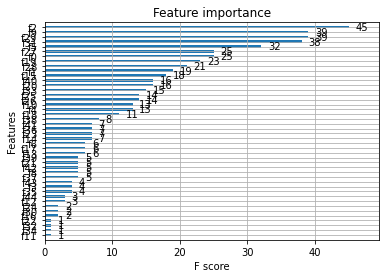

In [ ]:
xgboost.plot_importance(best_model, height = 0.5)

## If to use bayesian optimization directly without using the decorator

In [ ]:
def _opt_xgboost(n_estimators, max_depth, min_child_weight, gamma,learning_rate,  subsample):
    """
    This is the running engine function that takes an estimator/model object and a loss function 

    """
    estimator = XGBClassifier(n_estimators = int(n_estimators), max_depth= int(max_depth),   min_child_weight=min_child_weight, 
        gamma = gamma,learning_rate = learning_rate, subsample=subsample)
    return cross_val_score(estimator, X=x, y=y).mean()

In [ ]:
from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(_opt_xgboost, pbounds=params_xgboost)
optimizer.maximize(init_points = 3, n_iter = 2)


|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------
|  1        |  0.879    |  6.988    |  0.2875   |  5.244    |  0.1649   |  86.7     |  0.6816   |
|  2        |  0.813    |  24.91    |  0.1023   |  10.09    |  0.3515   |  36.04    |  0.8614   |
|  3        |  0.878    |  4.619    |  0.06144  |  8.307    |  0.2066   |  60.46    |  0.4185   |
|  4        |  0.873    |  6.144    |  0.255    |  4.219    |  0.07137  |  86.13    |  0.5942   |
|  5        |  0.833    |  16.14    |  0.3      |  12.0     |  0.6      |  90.91    |  1.0      |
